# Data Science Final Project

* Author: Karen Chik
* Email: kchik@scu.edu
* I certify that this notebook represents my own work for the Data Science with Python class in Santa Clara University.


# Looking at bikeshare data in the Bay Area

This project analyzes a dataset that represents every transaction of bikes in the Bay Area rented from 8/29/2013 to 9/1/2014.
http://www.bayareabikeshare.com/

Questions to address:
* Do users rent bikes to go to work and get off work at different times in each city?
* Are there enough bikes in each city? 
Utilization rate: # of times bike used/count of bikes per city
* Where should Bay Area Bike Share add more bikes?

In [46]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Reading, merging, and cleaning data

In [47]:

station = pd.read_csv("data/station.csv",parse_dates=True)
bike= pd.read_csv("data/trip.csv")

#left merge with start_station_name as the index to match city names
master= pd.merge(bike, station, left_on = 'start_station_name',right_on='name', left_index=False,right_index=False,how='left')
#use lambda to split the date and time
master['date'], master['start_time'] = zip(*master['start_date'].map(lambda x: x.split(' ')))
master['enddate'], master['end_time'] = zip(*master['end_date'].map(lambda x: x.split(' ')))

#clean data down to start time per hour
master['starthour'],master['minutes'] = zip(*master['start_time'].map(lambda x: x.split(':')))
master['endhour'],master['endminutes'] = zip(*master['end_time'].map(lambda x: x.split(':')))
master.starthour = master.starthour.astype(float)
master.endhour = master.endhour.astype(float)

#convert duration to minutes
master['duration_mins']= (master['duration']/60).round(decimals=2)
master = master.dropna(subset=['city'])


# When is the most popular time to rent a bike?

Axes(0.125,0.125;0.775x0.775)


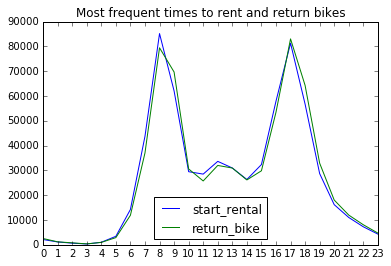

In [48]:
hr_change = pd.DataFrame()
hr_change['start_rental']= pd.value_counts(master['starthour'].values, sort=True)
hr_change['return_bike']= pd.value_counts(master['endhour'].values, sort=True)
hr_change.sort_index(inplace=True)
print hr_change.plot(xticks= hr_change.index, title= 'Most frequent times to rent and return bikes')

# Insight: 
* Peak hours to rent bikes: 8 am and 5 pm (normal start and closing hours for office workers)
* Same frequency in peak rental and return hours , implying short rental duration (within an hour)
* There is a spike during lunch hours, possible errands done during lunch hours.

#  Popular bike rental times by city

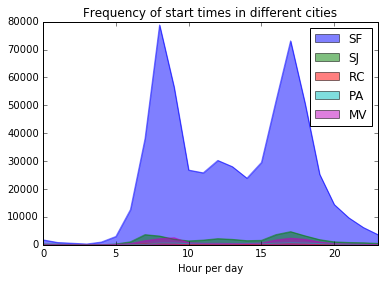

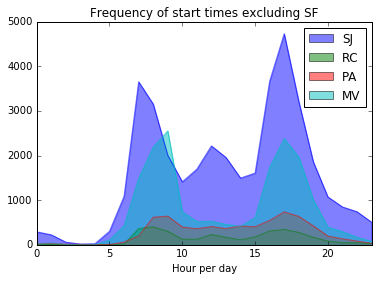

In [49]:

hr_change.sort_index(inplace=True)
c = master.city.unique()
hr_change['startcount']= pd.value_counts(master['starthour'].values, sort=True)

sf = master[(master.city == 'San Francisco')]
sj = master[(master.city == 'San Jose')]
rc= master[(master.city == 'Redwood City')]
pa = master[(master.city == 'Palo Alto')]
mv = master[(master.city == 'Mountain View')]

all_city= pd.DataFrame()
all_city['SF'] = pd.value_counts(sf['starthour'].values,sort=True)
all_city['SJ'] = pd.value_counts(sj['starthour'].values,sort=True)
all_city['RC'] = pd.value_counts(rc['starthour'].values,sort=True)
all_city['PA'] = pd.value_counts(pa['starthour'].values,sort=True)
all_city['MV'] = pd.value_counts(mv['starthour'].values,sort=True)

all_city.sort_index(inplace=True)

plot1= all_city.plot.area(stacked=False, title= 'Frequency of start times in different cities')
plot1.set_xlabel("Hour per day")

no_sf = all_city[['SJ','RC','PA','MV']]
plot2=no_sf.plot.area(stacked=False, title= 'Frequency of start times excluding SF')
plot2.set_xlabel("Hour per day")


In [50]:
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot

TOOLS = 'resize,pan,wheel_zoom,box_zoom,reset,hover'
p = figure(tools=TOOLS, x_range=(0, 24), y_range=(500, 80000),
           title="Count of Bike Rental Start Time by City")
hrs = [str(hr) for hr in range(0, 24)]

p.line(hrs, all_city['SF'], line_width= 4, color='#A6CEE3', legend='San Francisco')
p.line(hrs, all_city['SJ'], line_width=4, color='#e3bba6', legend='San Jose')
p.line(hrs, all_city['PA'], line_width=4, color='#00cccc', legend='Palo Alto')
p.line(hrs, all_city['MV'], line_width=4, color='#B2DF8A', legend='Mountain View')
p.line(hrs, all_city['RC'], line_width=4, color='#e3a6ce', legend='Redwood City')
p.legend.location = 'top_left'
output_file("starttime_city.html")

show(p)

# Popular start times based on city
* San Jose= 7 am 
* Redwood City= 7 am
* Palo Alto= 8 am
* San Francisco= 8 am
* Mountain View= 9 am
* All cities = 5 pm 
* Should we live and work in Mountain View?
* Possible explanations: 
* Seems like people using BikeShare rent bikes to get to work at various hours based on city, yet the majority of the people get off work at 5 pm to rent these bikes again 
* BikeShare users in Mountain View may live and work close to Mountain View, where as users in San Jose and Redwood City most likely commute to other cities

# Are there enough bikes in each city?

In [51]:
docks = station.groupby("city").agg({"dock_count": np.sum, "id": pd.Series.nunique})
del docks['id']
docks['trips']=master['city'].value_counts()
grouped= master.groupby('city')
docks['avgduration']= grouped['duration_mins'].agg([np.mean])
#bike utilization: number of times bikes have been rented in each city vs available bikes in each city
docks['bike_util']= docks['trips']/docks['dock_count']
docks.sort_values(['bike_util'],ascending=False)

docks


,dock_count,trips,avgduration,bike_util
city,,,,
Mountain View,117,18167,29.894023,155.273504
Palo Alto,75,6773,71.309598,90.306667
Redwood City,115,3366,40.638345,29.269565
San Francisco,665,592456,17.050504,890.911278
San Jose,264,37855,23.012966,143.390152


Axes(0.125,0.125;0.775x0.775)


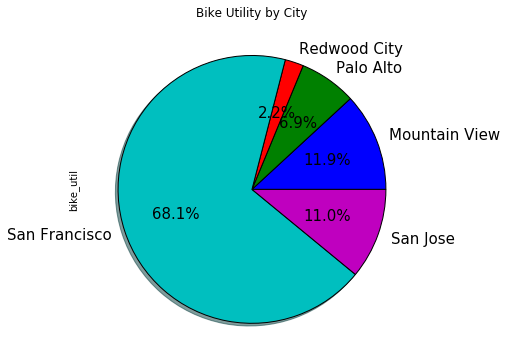

In [40]:
print docks['bike_util'].plot.pie(title= 'Bike Utility by City',fontsize=15,figsize= (6,6),autopct='%.1f%%', shadow= True)

In [41]:
docks1= pd.concat([docks['avgduration'],docks['bike_util']],axis=1)
docks1= docks1.sort_values(['bike_util'],ascending=False)

docks1

,avgduration,bike_util
city,,
San Francisco,17.050504,890.911278
Mountain View,29.894023,155.273504
San Jose,23.012966,143.390152
Palo Alto,71.309598,90.306667
Redwood City,40.638345,29.269565


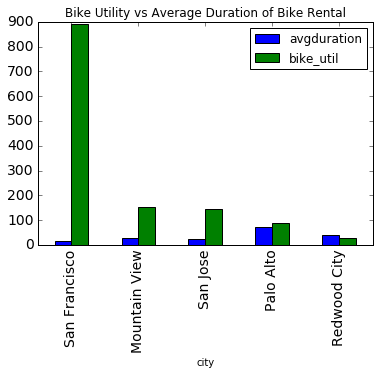

In [42]:

docks1.plot(kind='bar', fontsize=14, title='Bike Utility vs Average Duration of Bike Rental')


# Insight:
* San Francisco's bike utility is 68% compared to Redwood City's 2.2%. 
* Although San Francisco has the highest bike utilization, the average duration of bike rental is the lowest, compared to Palo Alto and Redwood City that have the lowest bike utility but the highest average duration.
* Opportunity to add more bikes to San Francisco 
* Assumption: do not take away bikes from Palo Alto or Redwood City, always opportunity for more people to use bikes since Silicon Valley is always growing. San Francisco will not be slowing down anytime soon, so it makes sense to add bikes to maintain customer satisfaction and acquire new customers.

# Add more bikes to specific docks in SF

In [43]:

sfbikes = sf.groupby("start_station_name").agg({"dock_count": np.mean, "id_x": pd.Series.nunique})
sfbikes=sfbikes.rename(columns = {'id_x':'Trips'})
sfbikes['bike_util']=sfbikes['Trips']/sfbikes['dock_count']
groupsf=sf.groupby("start_station_name")
sfbikes['avgduration']= groupsf['duration_mins'].agg([np.mean])

sfbikes = sfbikes.sort_values(['bike_util'],ascending=False)
sfbikes


,Trips,dock_count,bike_util,avgduration
start_station_name,,,,
San Francisco Caltrain (Townsend at 4th),49092,19.0,2583.789474,13.776114
Embarcadero at Sansome,27713,15.0,1847.533333,23.522228
Townsend at 7th,23724,15.0,1581.600000,11.275349
San Francisco Caltrain 2 (330 Townsend),33742,23.0,1467.043478,11.502374
Harry Bridges Plaza (Ferry Building),32934,23.0,1431.913043,24.916586
2nd at South Park,18496,15.0,1233.066667,11.464623
Temporary Transbay Terminal (Howard at Beale),26089,23.0,1134.304348,10.923937
Grant Avenue at Columbus Avenue,16306,15.0,1087.066667,19.997730
Steuart at Market,24838,23.0,1079.913043,15.595162


In [44]:
sfbikes.describe()
#High standard deviation for bike utilization indicates a lot more bike rentals in several stations


,Trips,dock_count,bike_util,avgduration
count,35.000000,35.000000,35.000000,35.000000
mean,16927.314286,19.000000,890.917764,18.152793
std,9553.954856,3.757346,479.303080,6.800992
min,1472.000000,15.000000,98.133333,9.695151
25%,11569.500000,15.000000,660.742105,13.416485
50%,14102.000000,19.000000,792.533333,15.760300
75%,21998.000000,21.000000,1070.614416,21.049663
max,49092.000000,27.000000,2583.789474,40.026776


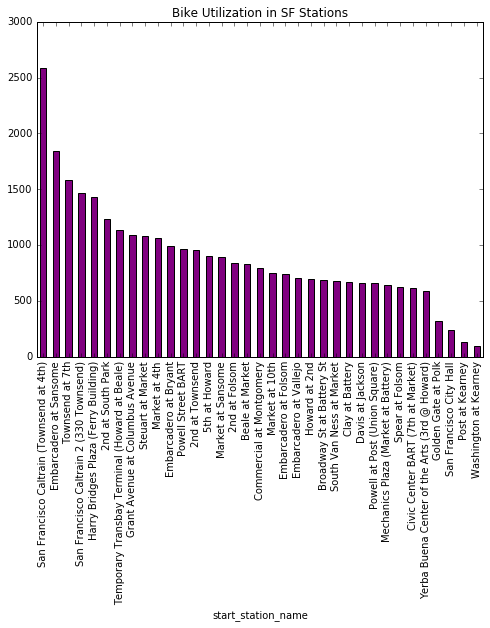

In [45]:
sfbikes['bike_util'].plot.bar(color='purple', title = 'Bike Utilization in SF Stations', figsize= (8,6))


# Business Recommendations:

* #1: Increase bikes at the top 5 stations where bike util is the highest
* #2: Expansion plans to create new dock stations near the top 5 stations
* #3: If advertising spaces are available at specific docks stations, Bay Area Bike Share should charge more for ad space at the most popular dock stations. If advertising spaces not available, Bay Area Bike Share should consider it to increase revenue stream.



# Conclusion
* Do users rent bikes to go to work and get off work at different times in each city?
On average, users in different cities go to work at different times, but get off work at the same time.
* Are there enough bikes in each city? 
No, especially San Francisco with a high bike utilization rate
* Where should Bay Area Bike Share add more bikes?
Top 5 stations to add bikesin San Francisco:
* San Francisco Caltrain (Townsend at 4th)
* Embarcadero at Sansome
* Townsend at 7th
* San Francisco Caltrain 2
* Harry Bridges Plaze (Ferry Building)